# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,SPY_open,SPY_high,SPY_low,SPY_close,TLT_open,TLT_high,TLT_low,TLT_close,GLD_open,GLD_high,GLD_low,GLD_close,TLT_SHRT_open,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,,,,,
1993-01-29,25.90,25.90,25.77,25.88,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-01,25.90,26.07,25.90,26.07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-02,26.05,26.14,25.99,26.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-03,26.16,26.42,26.14,26.40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1993-02-04,26.49,26.57,26.20,26.51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,390.03,394.07,389.97,392.59,135.69,136.41,135.37,136.26,162.27,163.13,162.16,163.00,135.69,136.41,135.37,136.26
2021-03-23,391.91,393.46,388.66,389.50,136.59,137.54,136.15,137.49,162.45,162.49,161.59,161.81,136.59,137.54,136.15,137.49
2021-03-24,391.00,392.75,387.47,387.52,137.06,138.28,136.95,138.23,162.21,162.89,161.94,162.37,137.06,138.28,136.95,138.23


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=2)
pf.TradeLog.instance

{'SPY': <pinkfish.trade.TradeLog at 0x7f25d0063dc0>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f25d00639a0>,
 'GLD': <pinkfish.trade.TradeLog at 0x7f25d0063d00>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7f25d0063c10>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    p = portfolio.get_prices(row, fields=['close'])

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            close = p[symbol]['close']
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, close, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,85.96,116,entry,LONG,SPY
1,2004-12-01,1,51.02,117,entry,LONG,TLT
2,2004-12-01,2,45.38,44,entry,LONG,GLD
3,2004-12-01,3,51.02,39,entry,SHRT,TLT_SHRT
4,2005-01-03,4,52.57,2,exit,LONG,TLT
5,2005-01-03,5,43.02,3,entry,LONG,GLD
6,2005-01-03,6,52.57,1,exit,SHRT,TLT_SHRT
7,2005-02-01,7,86.13,1,entry,LONG,SPY
8,2005-02-01,8,54.24,4,exit,LONG,TLT
9,2005-02-01,9,42.10,1,entry,LONG,GLD


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
533,2017-10-02,115.48,2021-03-26,136.66,-21.18,-63.54,3,83889.51,SHRT,TLT_SHRT
534,2017-11-01,241.42,2021-03-26,395.98,154.56,154.56,1,84044.07,LONG,SPY
535,2017-11-01,116.16,2021-03-26,136.66,20.50,102.49,5,84146.57,LONG,TLT
536,2017-11-01,121.11,2021-03-26,162.24,41.13,82.26,2,84228.83,LONG,GLD
537,2017-11-01,116.16,2021-03-26,136.66,-20.50,-41.00,2,84187.83,SHRT,TLT_SHRT
...,...,...,...,...,...,...,...,...,...,...
628,2021-02-01,174.23,2021-03-26,162.24,-11.99,-83.93,7,96748.72,LONG,GLD
629,2021-02-01,151.82,2021-03-26,136.66,15.16,90.94,6,96839.66,SHRT,TLT_SHRT
630,2021-03-01,141.06,2021-03-26,136.66,-4.40,-149.60,34,96690.06,LONG,TLT
631,2021-03-01,161.53,2021-03-26,162.24,0.71,7.10,10,96697.16,LONG,GLD


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-03-22,113446.67,113446.67,113446.67,1071,-109500.81,1.97,-
2021-03-23,112783.13,112783.13,112783.13,1071,-109500.81,1.97,-
2021-03-24,112527.58,112527.58,112527.58,1071,-109500.81,1.97,-
2021-03-25,112724.03,112724.03,112724.03,1071,-109500.81,1.97,-
2021-03-26,106745.56,106745.56,106745.56,0,106745.56,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2021-03-26
beginning_balance                                           10000
ending_balance                                          106745.56
total_net_profit                                         96745.56
gross_profit                                            111390.26
gross_loss                                              -14644.70
profit_factor                                                7.61
return_on_initial_capital                                  967.46
annual_return_rate                                          15.58
trading_period                           16 years 4 months 8 days
pct_time_in_market                                          99.81
margin                                                          2
avg_leverage                                                 1.93
max_leverage                                                 2.26
min_levera

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

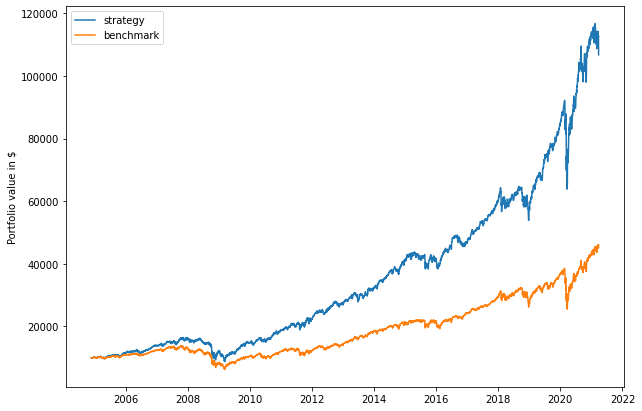

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

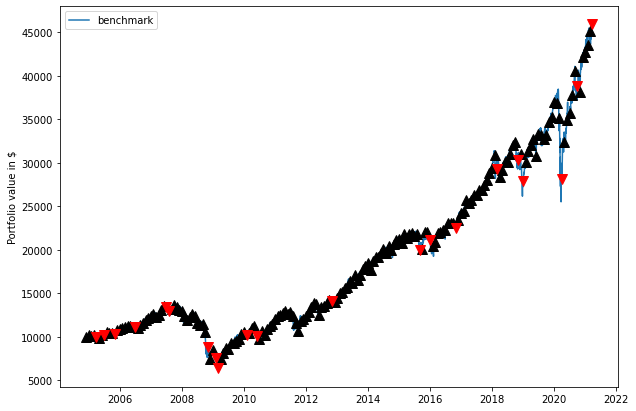

In [16]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [17]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$106,745.56","$46,003.86"
total_net_profit,"$96,745.56","$36,003.86"
gross_profit,"$111,390.26","$36,003.86"
gross_loss,"-$14,644.70",$0.00


,strategy,benchmark
annual_return_rate,15.58,9.78
max_closed_out_drawdown,-46.70,-54.91
annualized_return_over_max_drawdown,0.33,0.18
best_month,31.04,23.36
worst_month,-30.74,-30.93
sharpe_ratio,0.89,0.58
sortino_ratio,1.10,0.69
monthly_std,4.49,4.53
annual_std,15.76,15.55


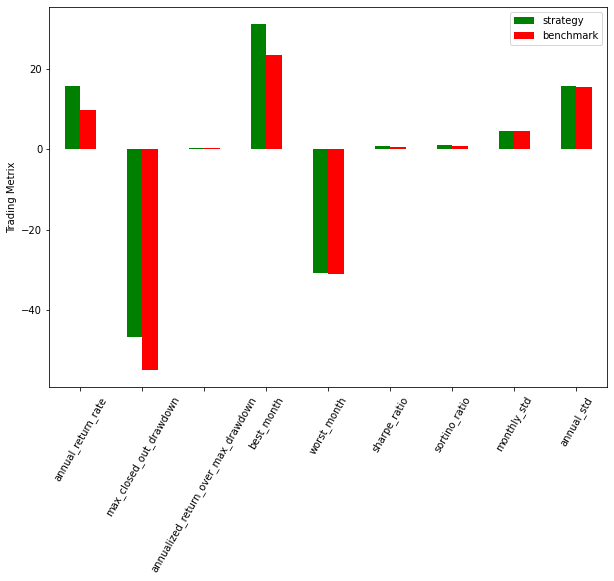

In [18]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df